# Regression Kriging: Comparing Covariates (Charlotte Harbor)

This document includes Python codes that compare regression kriging with 1) bathymatry, 2) LDI, 3) basymatry+ LDI.

All date are shared in the [box folder](https://usf.box.com/s/xu3dw4i1emv2hzveyf9idnx9q78t939c).

# Table of Contents:

* [1.Load Data](#load_data)
* [2. Combine Discrete and Continuous Data](#preprocess)
* [3. Charlotte Harbor](#ch)
    * [3.1 Preview](#ch_preview)
    * [3.2 Dissolved Oxygen](#do)
        * [3.2.1 Regression Kriging (covariate: bathymetry](#do_bathy)
        * [3.2.2 Regression Kriging: (covariate: LDI)](#do_ldi)
        * [3.2.3 Regression Kriging (covariate: bathymetry+LDI](#do_b_ldi)
        * [3.2.4 Interpolation Validation](#do_val)
    * [3.3 Salinity](#s)
        * [3.3.1 Regression Kriging (covariate: bathymetry](#s_bathy)
        * [3.3.2 Regression Kriging: (covariate: LDI)](#s_ldi)
        * [3.3.3 Regression Kriging (covariate: bathymetry+LDI](#s_b_ldi)
        * [3.3.4 Interpolation Validation](#s_val)
    * [3.4 Total Nitrogen](#tn)
        * [3.4.1 Regression Kriging of Total Nitrogen (covariate: bathymetry](#tn_bathy)
        * [3.4.2 Regression Kriging of Total Nitrogen: (covariate: LDI)](#tn_ldi)
        * [3.4.3 Regression Kriging of Total Nitrogen (covariate: bathymetry+LDI](#tn_b_ldi)
        * [3.4.4 Interpolation Validation of Total Nitrogen](#tn_val)
    * [3.5 Turbidity](#t)
        * [3.5.1 Regression Kriging of Turbidity (covariate: bathymetry](#t_bathy)
        * [3.5.2 Regression Kriging of Turbidity (covariate: LDI)](#t_ldi)
        * [3.5.3 Regression Kriging of Turbidity (covariate: bathymetry+LDI](#t_b_ldi)
        * [3.5.4 Interpolation Validation of Turbidity](#t_val)
    * [3.6 Secchi Depth](#sd)
        * [3.6.1 Regression Kriging of Secchi Depth (covariate: bathymetry](#sd_bathy)
        * [3.6.2 Regression Kriging of Secchi Depth: (covariate: LDI)](#sd_ldi)
        * [3.6.3 Regression Kriging of Secchi Depth (covariate: bathymetry+LDI](#sd_b_ldi)
        * [3.6.4 Interpolation Validation of Secchi Depth](#sd_val)

In [1]:
import time, math, os, importlib
import sklearn.metrics  
import arcgisscripting
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask
import rasterio.plot as rio_pl
import matplotlib.image as mpimg

from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio import MemoryFile
from rasterio.profiles import DefaultGTiffProfile
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
from shapely.geometry import box, Polygon, Point
from shapely import wkt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import contextily as cx

import arcpy
from arcpy.sa import *
import misc.preprocess
import misc.interpolation
arcpy.env.overwriteOutput = True

# 1. Load and Preprocess Data <a class="anchor" id="load_data"></a>

In [2]:
path = "E:/Projects/SEACAR_WQ_Pilot/"
gis_path = path+'GIS_data/'

# path = "D:/Water_Quailty/"
# gis_path = path+'Test02200/'

Preprocess the data and save the preprocessed data in new files

In [3]:
# dfDis, dfCon = misc.preprocess.preprocess(path + r"OEAT_Discrete-2023-Jan-23.csv", 
#                     path + r"OEAT_Continuous_1-2023-Jan-23.csv",
#                     path + r"OEAT_Continuous_2-2023-Jan-23.csv")

# dfDis.to_csv(path + "discrete_0214.csv")
# dfCon.to_csv(path + "continuous_0214.csv")

To save time, we can load the preprocessed "discrete_0214.csv" and "continuous_0214.csv".

In [4]:
#dfDis = pd.read_csv("D:/Water_Quailty/Test0214/discrete_0214.csv")
#dfCon = pd.read_csv("D:/Water_Quailty/Test0214/continuous_0214.csv")

dfDis = pd.read_csv(path + "discrete_0214.csv")
dfCon = pd.read_csv(path + "continuous_0214.csv")

C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\IPython\core\interactiveshell.py:3442: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]
para_ls_ab = ["S","TN","DO","T","SD"]
# Convert full MA names to short names
dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island'}

# Convert full MA names to MA name in ORCP_Managed_Areas_Oct2021
dictArea2    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Gasparilla Sound-Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend Seagrasses',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'Guana Tolomato Matanzas NERR','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island Sound'}

dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 

# 2. Combine Discrete and Continuous Data <a class="anchor" id="combine"></a>

Combine dis and con dataframes

In [6]:
# Set variables of the program
year = "2017"
Area = 'Gasparilla Sound-Charlotte Harbor Aquatic Preserve'
Para = 'Dissolved Oxygen'
Para_ab = "DO"
SpatialRef = '3086'
b_name = 'ch'

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'
boundary_shp = gis_path+ '{}.shp'.format(b_name)

# ---------------------------- Uncomment in the first run --------------------------
dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_16424\2000778011.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_16424\2000778011.py:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Skip the preprocessing and load the pre-stored dataframes

In [7]:
# gdfDryAll = pd.read_csv(gis_path+'gdfDryAll{}.csv'.format(year))
# gdfDryAll = gdfDryAll['geometry'].apply(wkt.loads)
# gdfDryAll = gpd.GeoDataFrame(gdfDryAll, crs='epsg:'+SpatialRef)

# gdfWetAll = pd.read_csv(gis_path+'gdfWetAll{}.csv'.format(year))
# gdfWetAll = gdfWetAll['geometry'].apply(wkt.loads)
# gdfWetAll = gpd.GeoDataFrame(gdfWetAll, crs='epsg:'+SpatialRef)

# 3. Charlotte Harbor <a class="anchor" id="ch"></a>
## 3.1 Preview Data <a class="anchor" id="ch_preview"></a>

In [8]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

ma_table = pd.read_csv(gis_path + "MA_table.csv")

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [9]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

Text(0.5, 1.0, 'Sampling points at Gasparilla Sound-Charlotte Harbor Aquatic Preserve')

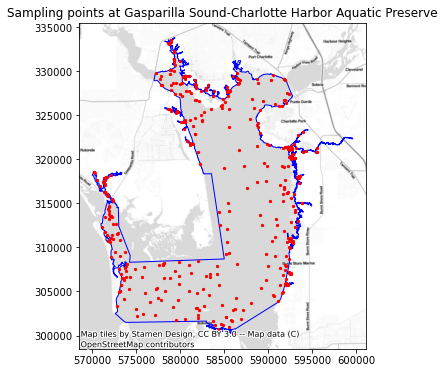

In [10]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 3.2 Dissolved Oxygen <a class="anchor" id="do"></a>

### 3.2.1 Regression Kriging (covariate: bathymetry) <a class="anchor" id="do_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

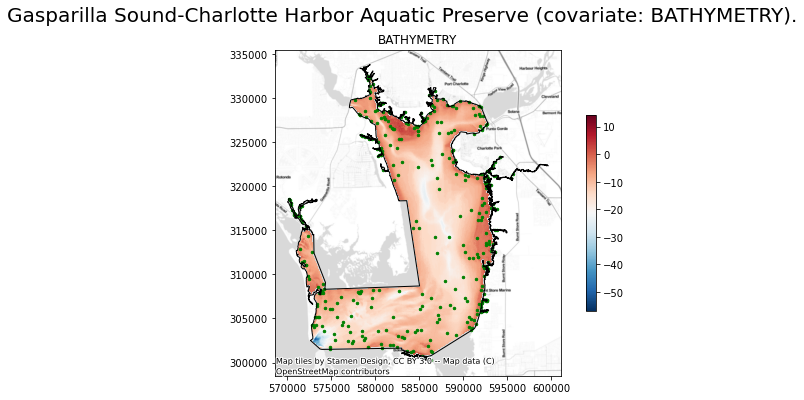

In [11]:
covariate = 'bathymetry'

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate.upper(), ax, fig)

RK interpolation

In [12]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK1, dryRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK1, wetRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 451.2534956932068 seconds ---
Start the interpolation with the RK method
--- Time lapse: 436.76534152030945 seconds ---


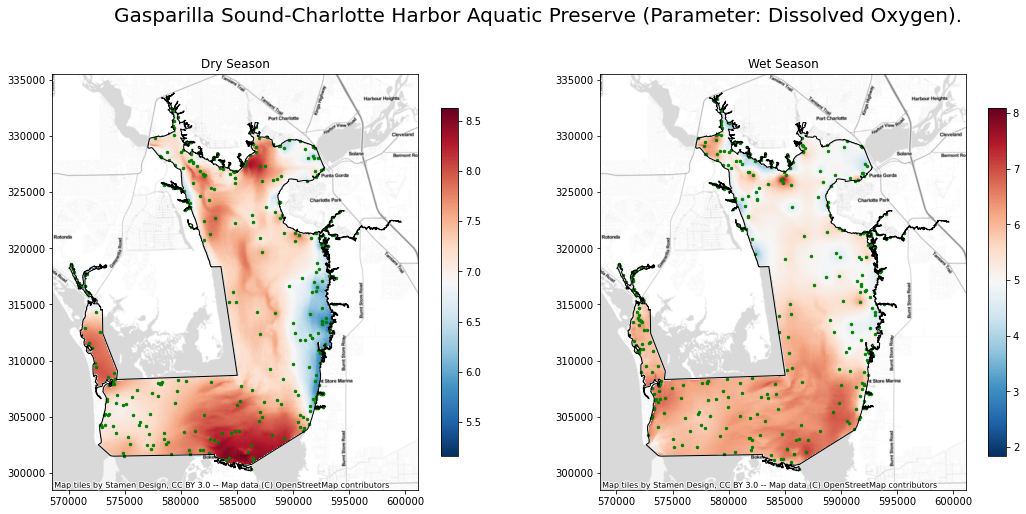

In [13]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK1, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK1, 'Wet Season', axes[1],fig)


### 3.2.2 Regression Kriging (covariate: LDI) <a class="anchor" id="do_ldi"></a>


RK interpolation

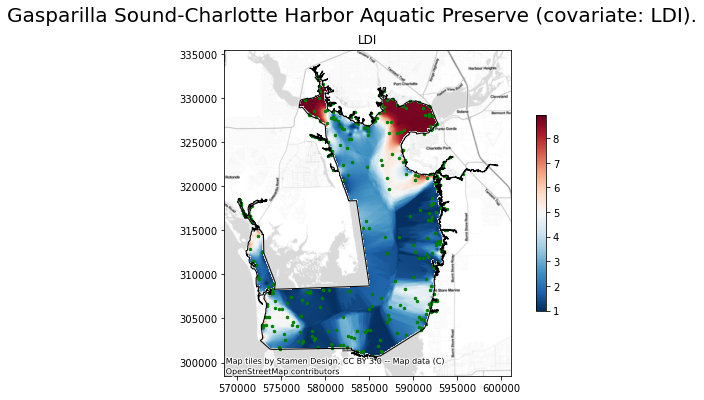

In [14]:
covariate = 'ldi'
fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname , covariate.upper(), ax, fig)

In [15]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK2, dryRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK2, wetRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 429.2974600791931 seconds ---
Start the interpolation with the RK method
--- Time lapse: 435.32997035980225 seconds ---


Plot the interpolation result

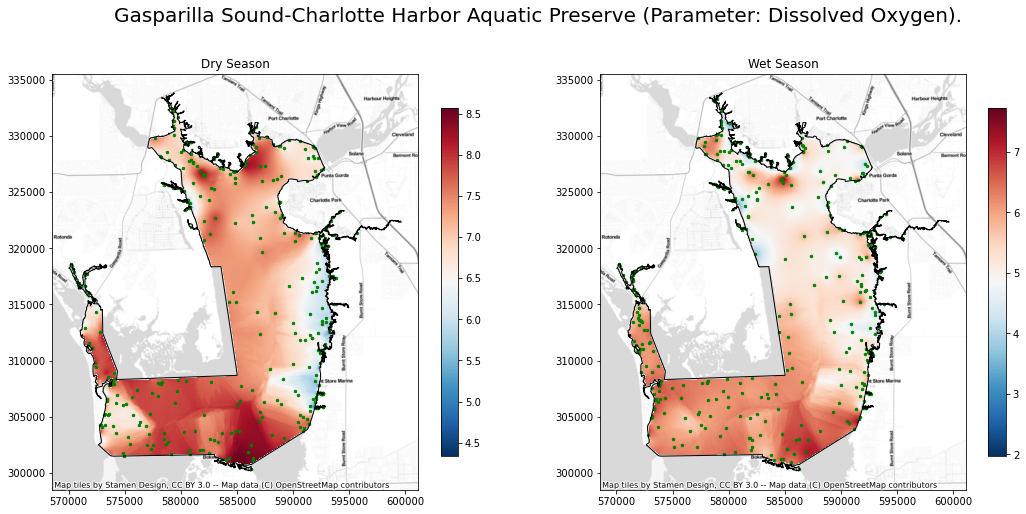

In [16]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK2, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK2, 'Wet Season', axes[1], fig)

### 3.2.3 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="do_ldi_bathy"></a>


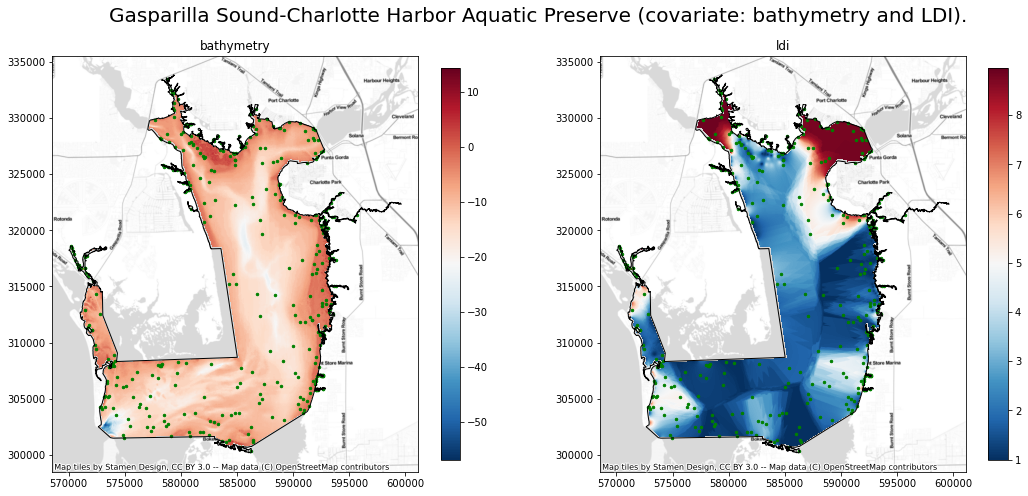

In [17]:
covariate1, covariate2 = 'bathymetry', 'ldi'

ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate1 ,ax[0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate2, ax[1], fig)

In [18]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

dryRK3, dryRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

wetRK3, wetRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 715.9462659358978 seconds ---
Start the interpolation with the RK method
--- Time lapse: 716.8766703605652 seconds ---


Plot interpolation results

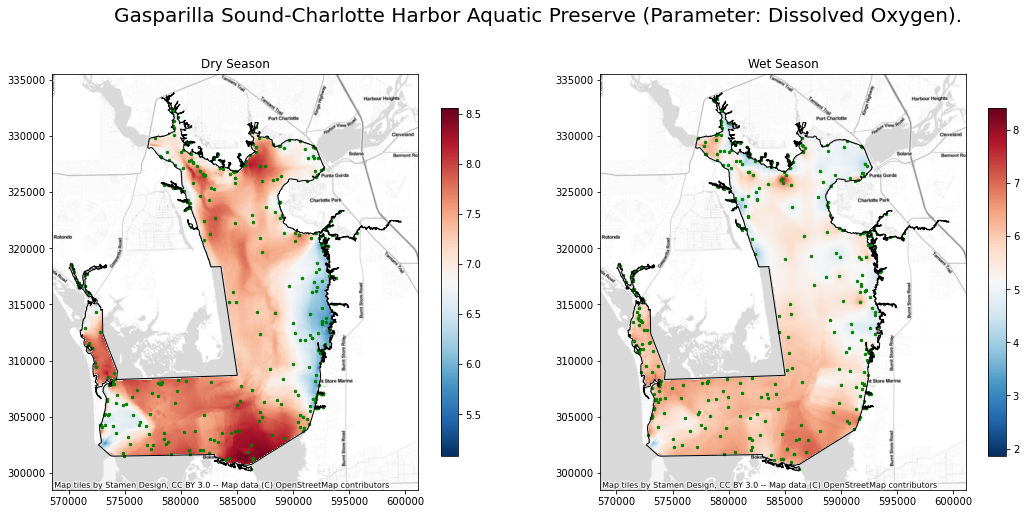

In [19]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK3, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK3, 'Wet Season', axes[1],fig)


### 3.2.4 Validation Summary <a class="anchor" id="do_val_sum"></a>

In [20]:
sumStatDry1   = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
print("Summary of interpolation assessment in dry season data")
sumStatDry1

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
RK     0.0187                 0.0123               1.6154
RK     0.0244                 0.0156               1.5903
RK     0.0421                 0.0239               1.5803

In [21]:
sumStatWet1   = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])
print("Summary of interpolation assessment in wet season data")
sumStatWet1

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
RK     0.0650                 0.0321               1.7821
RK     0.0400                 0.0187               1.7528
RK     0.0711                 0.0340               1.7747

## 3.3 Interpolation of Salinity <a class="anchor" id="s"></a>

Select salinity data

In [22]:
# Set variables of the program
year = "2017"
Para = 'Salinity'
Para_ab = "S"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

# ---------------------------- Uncomment in the first run --------------------------

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_16424\4049323852.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_16424\4049323852.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


In [23]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Gasparilla Sound-Charlotte Harbor Aquatic Preserve')

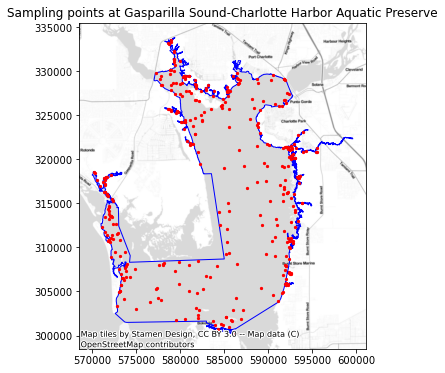

In [24]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

### 3.3.1 Regression Kriging of Salinity (covariate: bathymetry) <a class="anchor" id="s_bathy"></a>

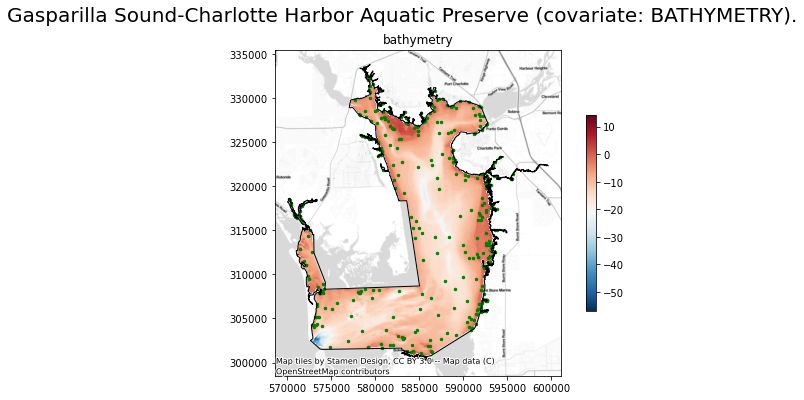

In [25]:
covariate = 'bathymetry'

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate, ax, fig)

RK interpolation

In [26]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK1, dryRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK1, wetRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 477.3634629249573 seconds ---
Start the interpolation with the RK method
--- Time lapse: 447.4604470729828 seconds ---


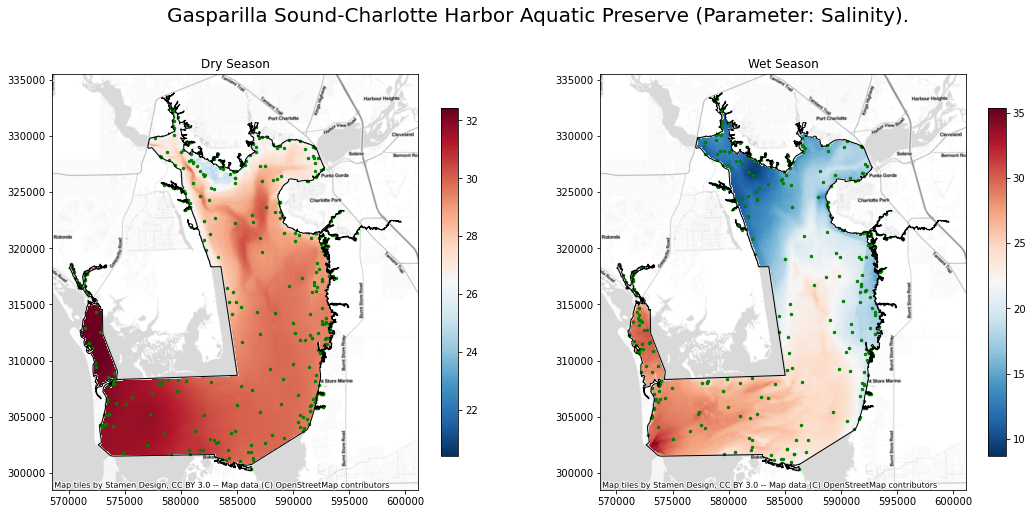

In [27]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK1, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK1, 'Wet Season', axes[1],fig)


### 3.3.2 Regression Kriging (covariate: LDI) <a class="anchor" id="s_ldi"></a>


RK interpolation

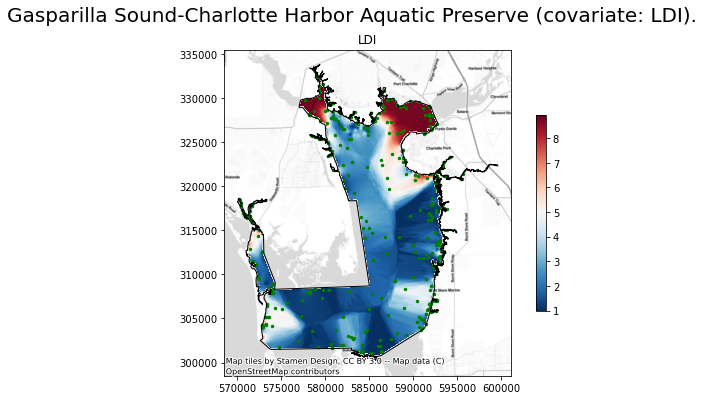

In [28]:
covariate = 'ldi'
fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname , covariate.upper(), ax, fig)

In [29]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK2, dryRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK2, wetRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 454.2633812427521 seconds ---
Start the interpolation with the RK method
--- Time lapse: 466.51648688316345 seconds ---


Plot the interpolation result

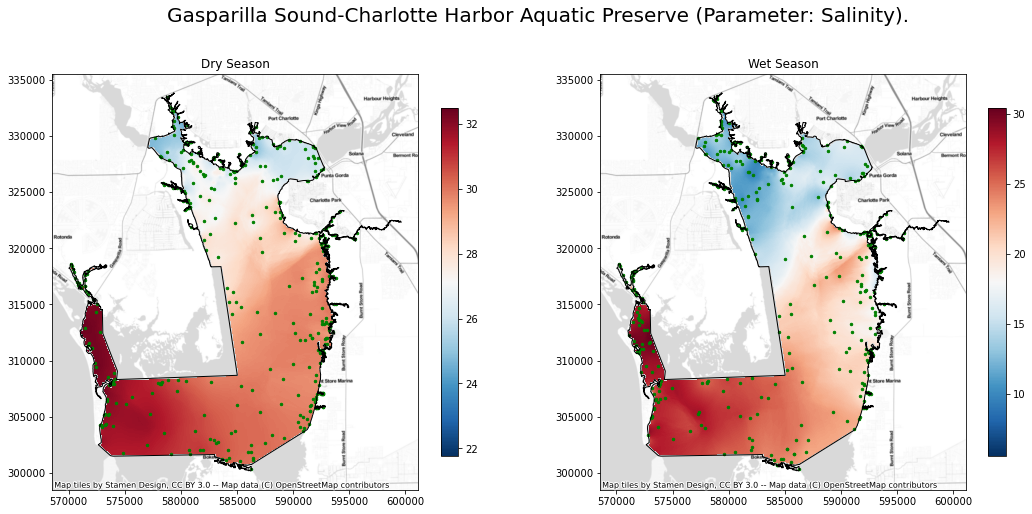

In [30]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK2, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK2, 'Wet Season', axes[1], fig)

### 3.3.3 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="si_ldi_bathy"></a>


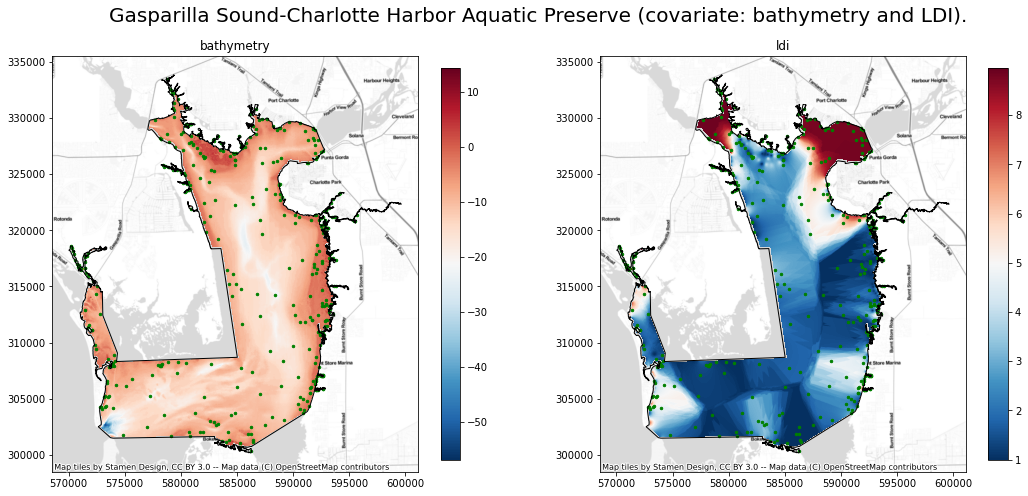

In [31]:
covariate1, covariate2 = 'bathymetry', 'ldi'

ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate1 ,ax[0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate2, ax[1], fig)

In [32]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

dryRK3, dryRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

wetRK3, wetRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 821.6740984916687 seconds ---
Start the interpolation with the RK method
--- Time lapse: 739.5268030166626 seconds ---


Plot interpolation results

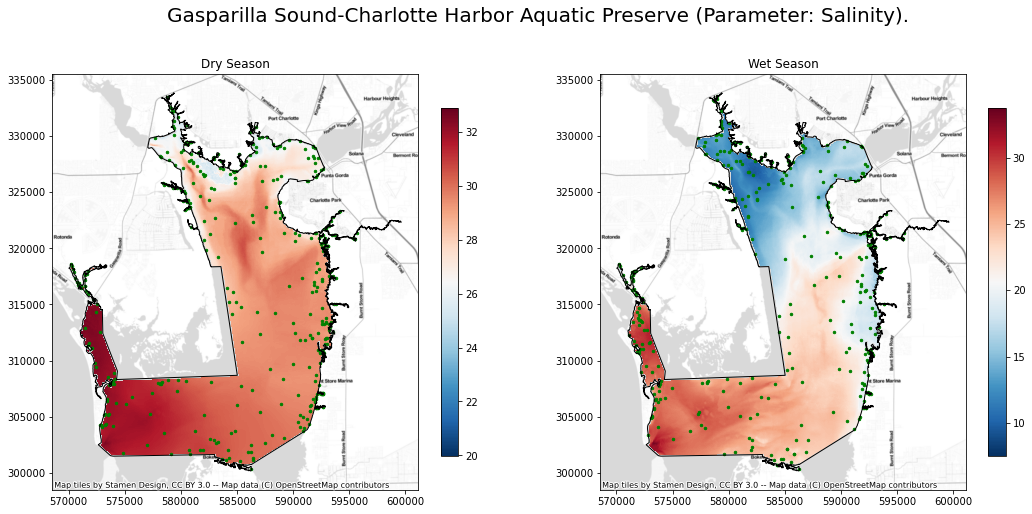

In [33]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK3, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK3, 'Wet Season', axes[1],fig)


### 3.3.4 Validation Summary <a class="anchor" id="s_val_sum"></a>

In [34]:
sumStatDry2   = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
print("Summary of interpolation assessment in dry season data")
sumStatDry2

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
RK    -0.0399                -0.0222               2.5193
RK    -0.0766                -0.0339               2.5219
RK    -0.0920                -0.0359               2.4049

In [35]:
sumStatWet2   = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])
print("Summary of interpolation assessment in wet season data")
sumStatWet2

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
RK     0.0070                -0.0050               8.8481
RK    -0.0824                -0.0170               8.9670
RK    -0.1274                -0.0189               8.8234

## 3.4 Interpolation of Total Nitrogen <a class="anchor" id="tn"></a>

Select data

In [36]:
# Set variables of the program
Para = 'Total Nitrogen'
Para_ab = "TN"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_16424\972659159.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_16424\972659159.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Preview data

In [37]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
b_name = 'ch'
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [38]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

Text(0.5, 1.0, 'Sampling points at Gasparilla Sound-Charlotte Harbor Aquatic Preserve')

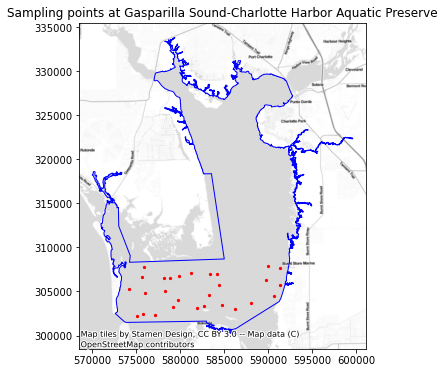

In [39]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

### 3.4.1 Regression Kriging of Total Nitrogen (covariate: bathymetry) <a class="anchor" id="tn_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

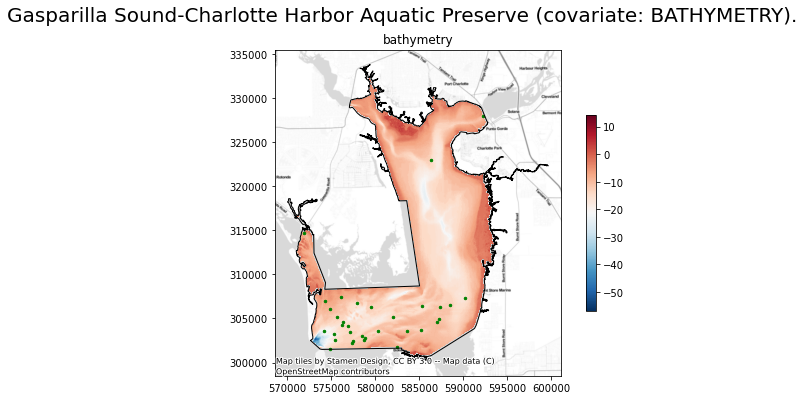

In [40]:
covariate = 'bathymetry'

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate, ax, fig)

RK interpolation

In [41]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK1, dryRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK1, wetRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 82.54836320877075 seconds ---
Start the interpolation with the RK method
--- Time lapse: 71.99210405349731 seconds ---


C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


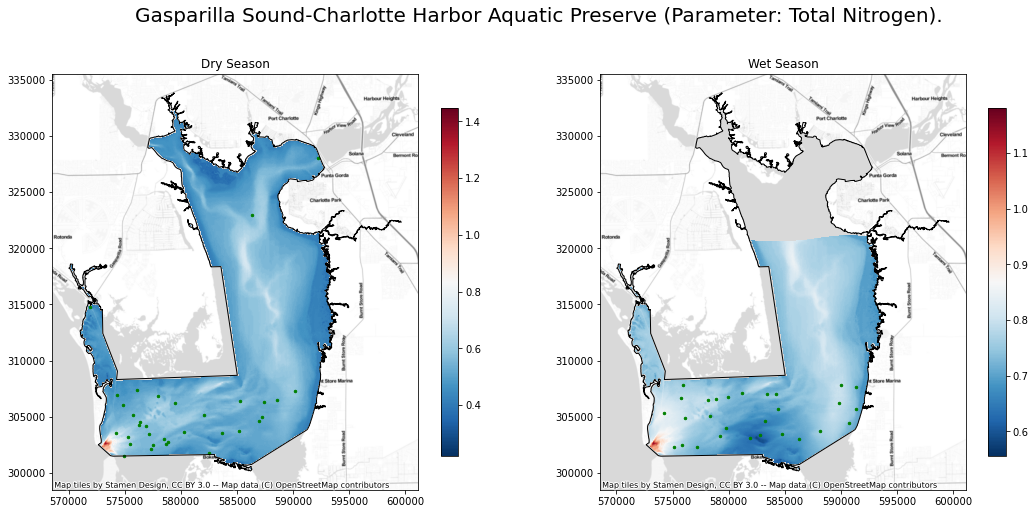

In [42]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK1, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK1, 'Wet Season', axes[1],fig)


### 3.4.2 Regression Kriging (covariate: LDI) <a class="anchor" id="tn_ldi"></a>


RK interpolation

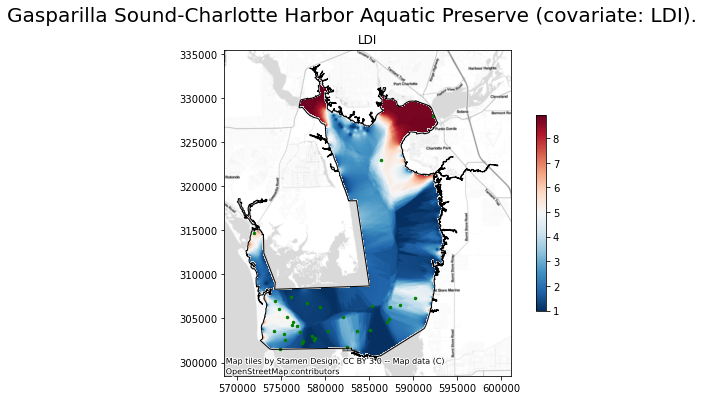

In [43]:
covariate = 'ldi'
fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname , covariate.upper(), ax, fig)

In [44]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK2, dryRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK2, wetRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 84.68120121955872 seconds ---
Start the interpolation with the RK method
--- Time lapse: 75.97698545455933 seconds ---


Plot the interpolation result

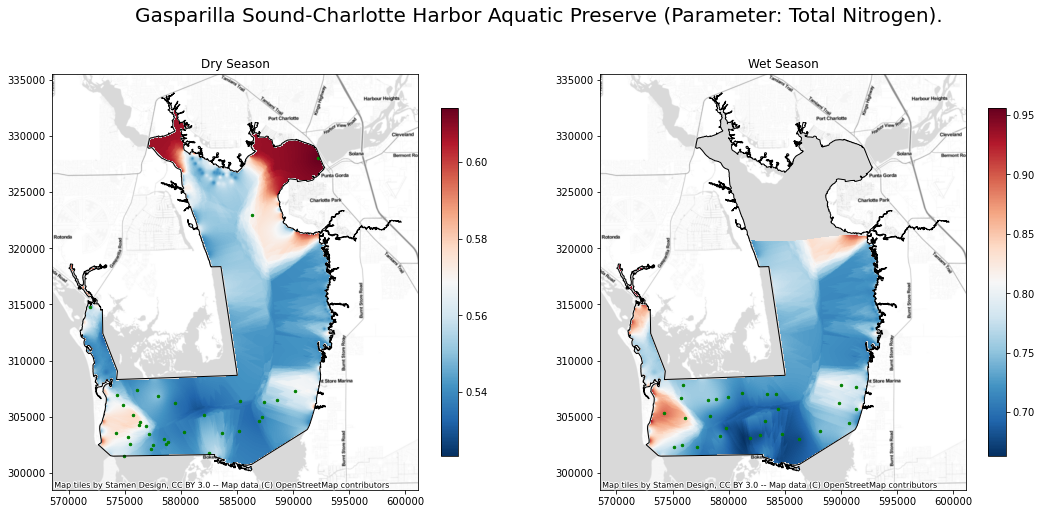

In [45]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK2, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK2, 'Wet Season', axes[1], fig)

### 3.4.3 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="tn_ldi_bathy"></a>


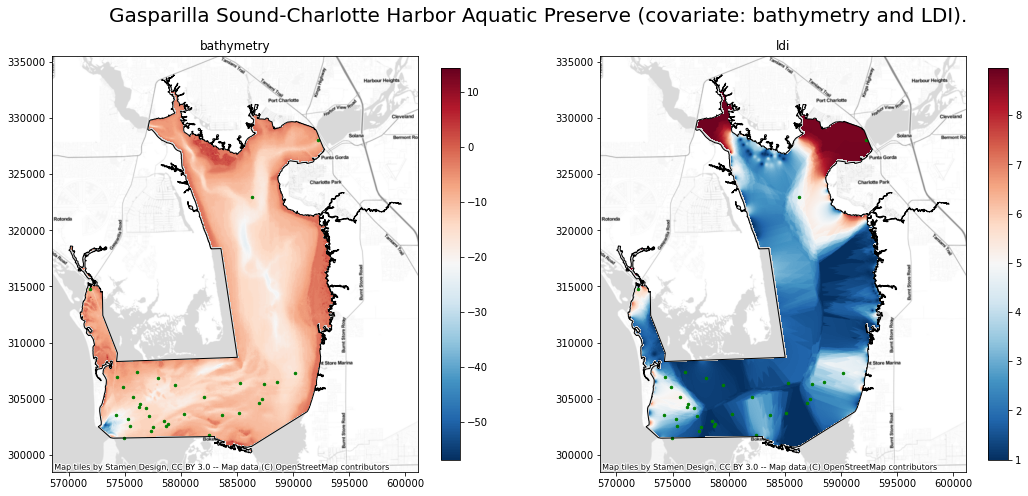

In [46]:
covariate1, covariate2 = 'bathymetry', 'ldi'

ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate1 ,ax[0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate2, ax[1], fig)

In [47]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

dryRK3, dryRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

wetRK3, wetRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 133.320782661438 seconds ---
Start the interpolation with the RK method
--- Time lapse: 123.70747566223145 seconds ---


Plot interpolation results

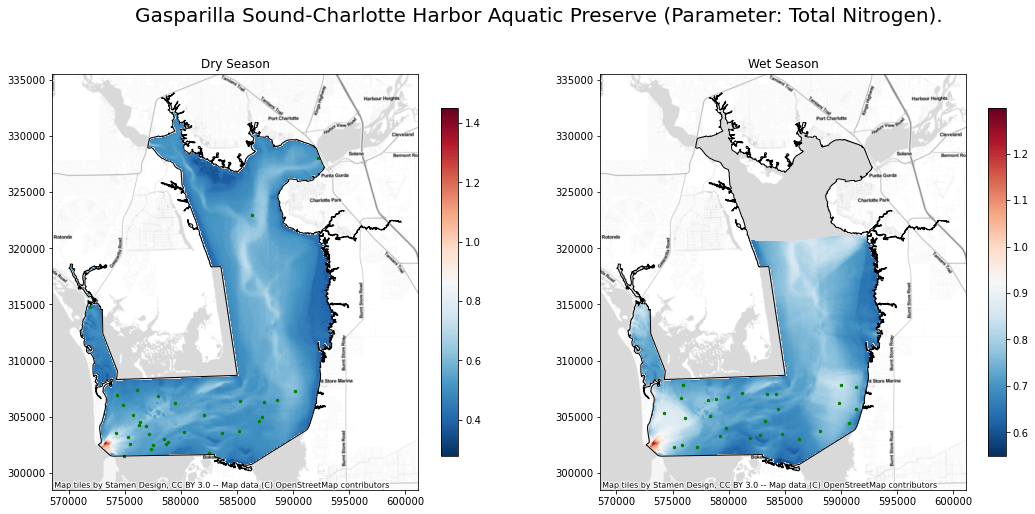

In [48]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK3, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK3, 'Wet Season', axes[1],fig)


### 3.4.4 Validation Summary <a class="anchor" id="tn_val_sum"></a>

In [49]:
sumStatDry1   = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
print("Summary of interpolation assessment in dry season data")
sumStatDry1

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
RK     0.0002                -0.0032               0.1204
RK     0.0013                 0.0102               0.1259
RK     0.0014                 0.0101               0.1191

In [50]:
sumStatWet1   = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])
print("Summary of interpolation assessment in wet season data")
sumStatWet1

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
RK     0.0044                 0.0319               0.1549
RK     0.0028                 0.0221               0.1527
RK     0.0082                 0.0541               0.1508

## 3.5 Interpolation of Turbidity <a class="anchor" id="t"></a>

Select data

In [55]:
year,Para,Para_ab = "2014", 'Turbidity', "T"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_16424\2848871626.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_16424\2848871626.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Preview data

In [56]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
b_name = 'ch'
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [57]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

Text(0.5, 1.0, 'Sampling points at Gasparilla Sound-Charlotte Harbor Aquatic Preserve')

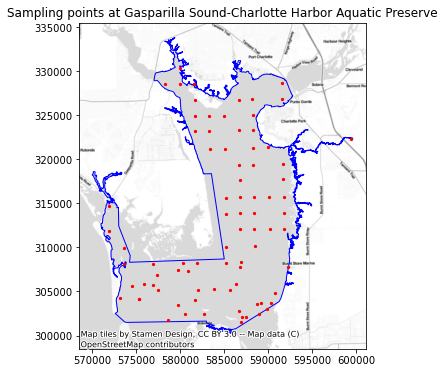

In [58]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

### 3.5.1 Regression Kriging of Turbidity (covariate: bathymetry) <a class="anchor" id="t_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

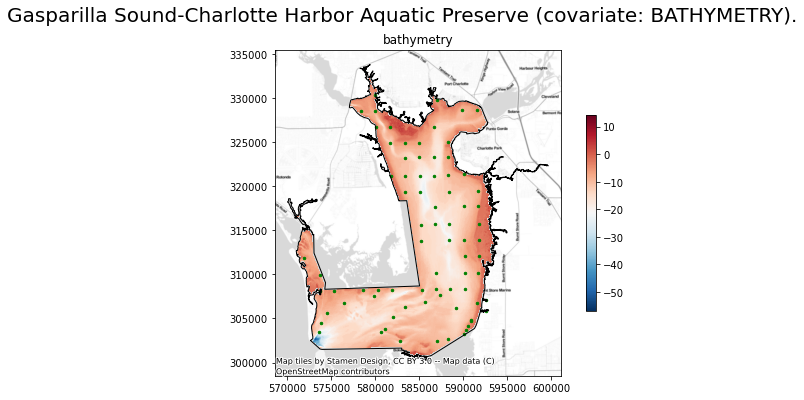

In [59]:
covariate = 'bathymetry'

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate, ax, fig)

RK interpolation

In [60]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK1, dryRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK1, wetRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 158.5354506969452 seconds ---
Start the interpolation with the RK method
--- Time lapse: 179.27548575401306 seconds ---


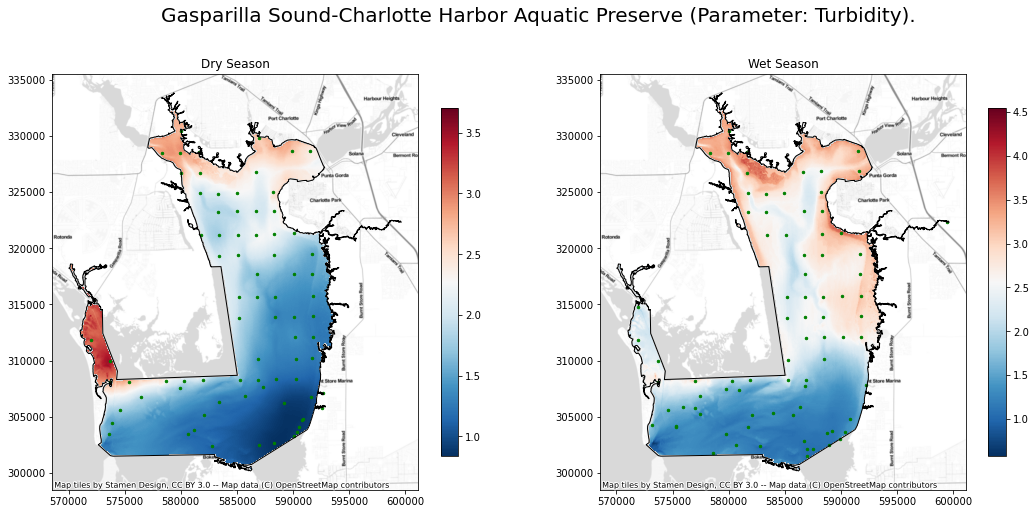

In [61]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK1, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK1, 'Wet Season', axes[1],fig)


### 3.5.2 Regression Kriging (covariate: LDI) <a class="anchor" id="t_ldi"></a>


RK interpolation

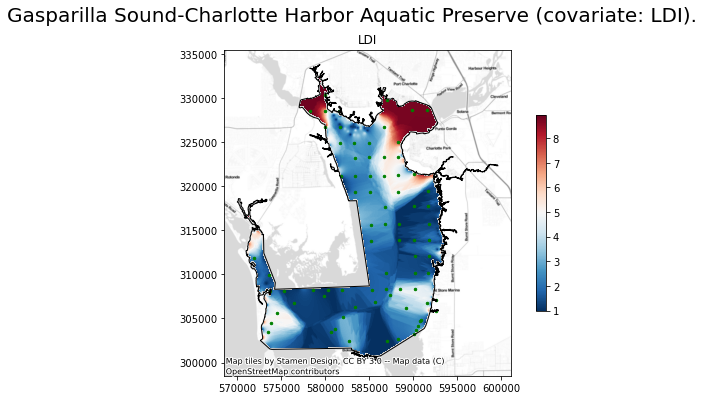

In [62]:
covariate = 'ldi'
fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname , covariate.upper(), ax, fig)

In [63]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK2, dryRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK2, wetRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 177.42938470840454 seconds ---
Start the interpolation with the RK method
--- Time lapse: 167.90399384498596 seconds ---


Plot the interpolation result

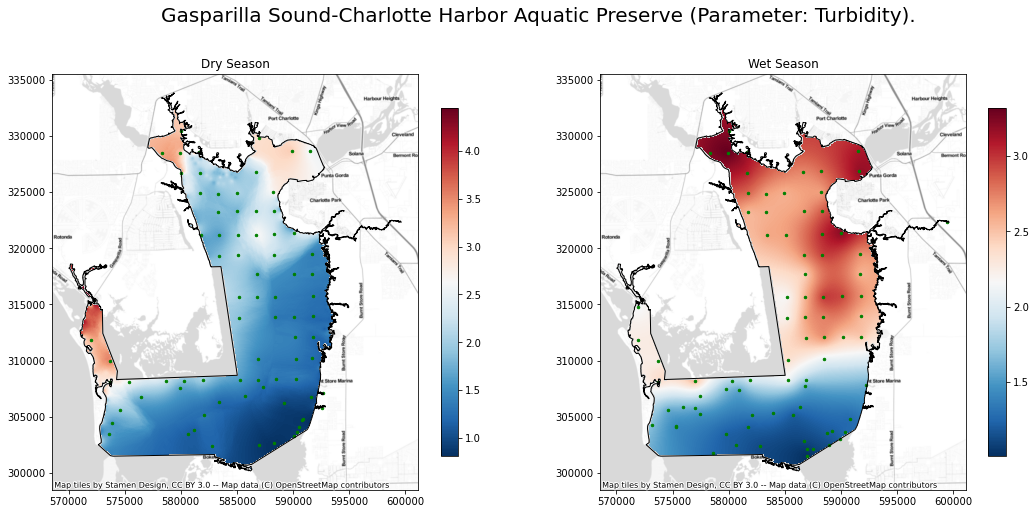

In [64]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK2, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK2, 'Wet Season', axes[1], fig)

### 3.5.3 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="t_ldi_bathy"></a>


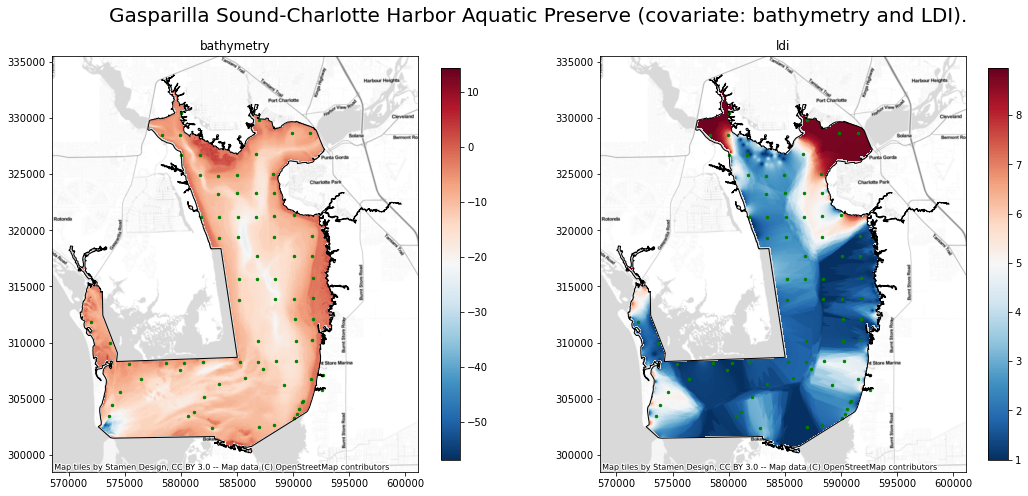

In [65]:
covariate1, covariate2 = 'bathymetry', 'ldi'

ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate1 ,ax[0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate2, ax[1], fig)

In [66]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

dryRK3, dryRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

wetRK3, wetRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 248.31827449798584 seconds ---
Start the interpolation with the RK method
--- Time lapse: 291.79627084732056 seconds ---


Plot interpolation results

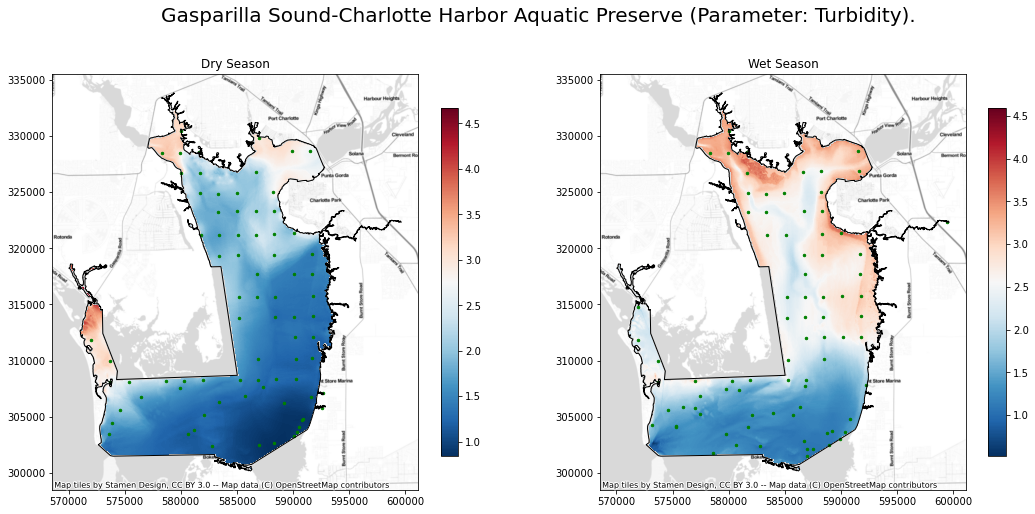

In [67]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK3, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK3, 'Wet Season', axes[1],fig)


### 3.5.4 Validation Summary <a class="anchor" id="t_val_sum"></a>

In [68]:
sumStatDry1   = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
print("Summary of interpolation assessment in dry season data")
sumStatDry1

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
RK    -0.0024                -0.0010               1.1318
RK     0.0036                 0.0021               1.1119
RK     0.0009                 0.0016               1.1320

In [69]:
sumStatWet1   = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])
print("Summary of interpolation assessment in wet season data")
sumStatWet1

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
RK     0.0115                 0.0074               1.2646
RK    -0.0030                -0.0069               1.2689
RK     0.0014                -0.0010               1.2630

## 3.6 Interpolation of Secchi Depth <a class="anchor" id="sd"></a>

Select data

In [70]:
year,Para,Para_ab = "2015", 'Secchi Depth', "SD"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_16424\3778504018.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_16424\3778504018.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Preview data

In [71]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
b_name = 'ch'
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [72]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

Text(0.5, 1.0, 'Sampling points at Gasparilla Sound-Charlotte Harbor Aquatic Preserve')

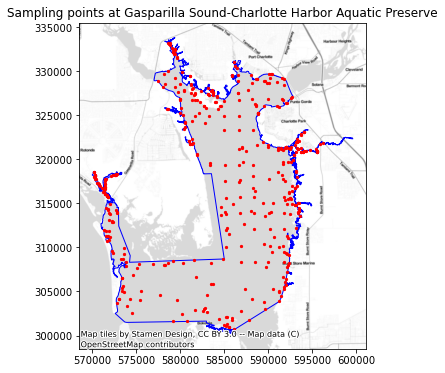

In [73]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

### 3.6.1 Regression Kriging of Turbidity (covariate: bathymetry) <a class="anchor" id="sd_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

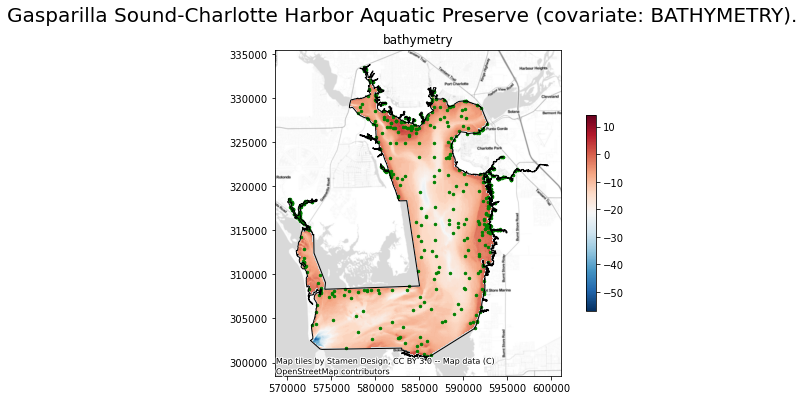

In [88]:
covariate = 'bathymetry'

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate, ax, fig)

RK interpolation

In [89]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK1, dryRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK1, wetRKStat1 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 504.66655945777893 seconds ---
Start the interpolation with the RK method
--- Time lapse: 544.4342105388641 seconds ---


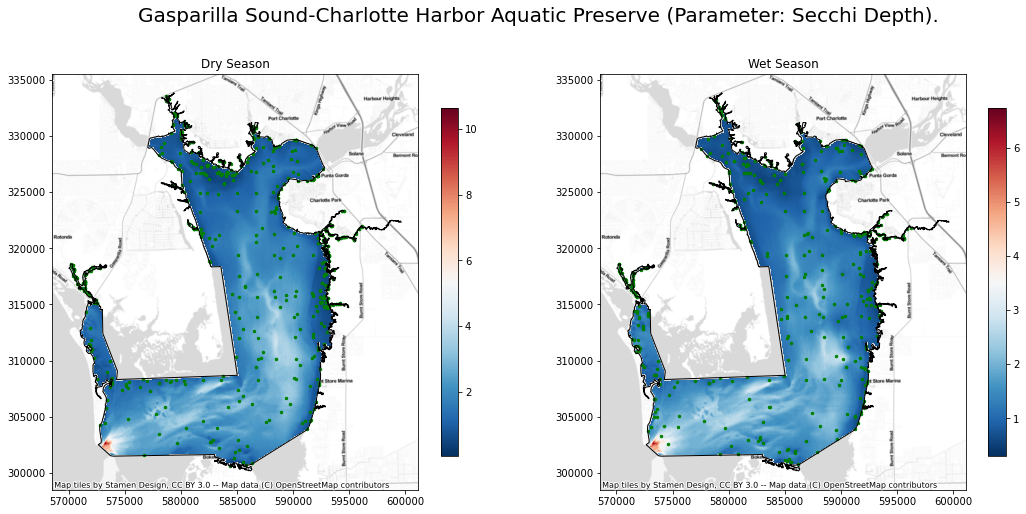

In [90]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK1, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK1, 'Wet Season', axes[1],fig)


### 3.6.2 Regression Kriging (covariate: LDI) <a class="anchor" id="sd_ldi"></a>


RK interpolation

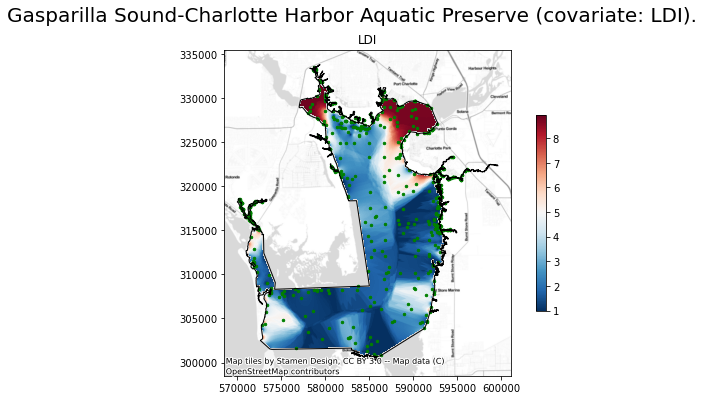

In [91]:
covariate = 'ldi'
fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, covariate.upper()),fontsize=20)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname , covariate.upper(), ax, fig)

In [92]:
season, method, value_field, mask = 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

dryRK2, dryRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK2, wetRKStat2 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 477.07024002075195 seconds ---
Start the interpolation with the RK method
--- Time lapse: 523.7403638362885 seconds ---


Plot the interpolation result

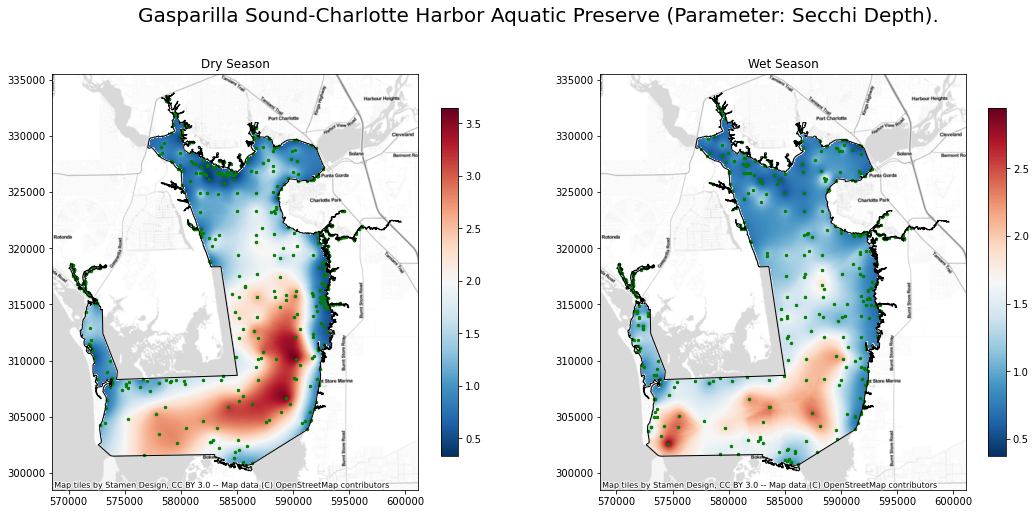

In [93]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK2, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK2, 'Wet Season', axes[1], fig)

### 3.6.3 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="sd_ldi_bathy"></a>


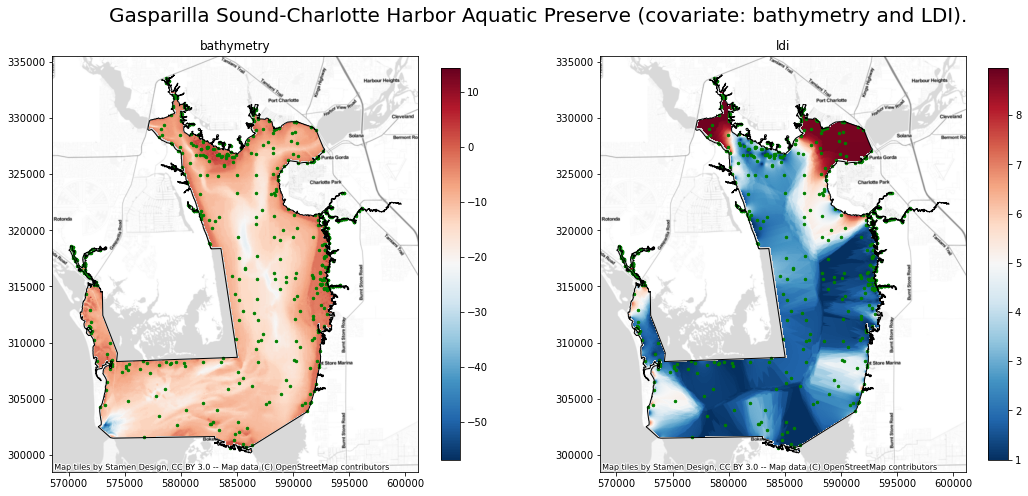

In [94]:
covariate1, covariate2 = 'bathymetry', 'ldi'

ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {} and {}).".format(Area, covariate1, covariate2.upper()),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate1 ,ax[0], fig)

ra_fname = gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname, covariate2, ax[1], fig)

In [95]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = [gis_path + "covariates/{}/{}.tif".format(covariate1,dictArea[Area]),
                          gis_path + "covariates/{}/{}.tif".format(covariate2,dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate1[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

dryRK3, dryRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:1]+'_'+covariate2[0:3])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate1[0:1]+'_'+covariate2[0:3])

wetRK3, wetRKStat3 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Start the interpolation with the RK method
--- Time lapse: 936.1483619213104 seconds ---
Start the interpolation with the RK method
--- Time lapse: 988.6900696754456 seconds ---


Plot interpolation results

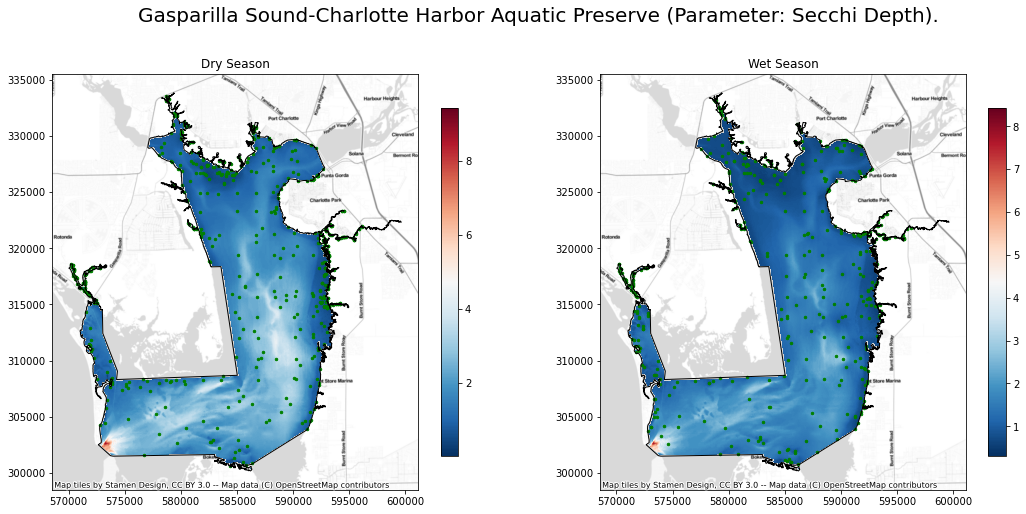

In [96]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK3, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK3, 'Wet Season', axes[1],fig)

### 3.6.4 Validation Summary <a class="anchor" id="sd_val_sum"></a>

In [97]:
sumStatDry1   = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
print("Summary of interpolation assessment in dry season data")
sumStatDry1

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
RK    -0.0198                -0.0287               0.4286
RK    -0.0150                -0.0175               0.4406
RK    -0.0176                -0.0218               0.4291

In [98]:
sumStatWet1   = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])
print("Summary of interpolation assessment in wet season data")
sumStatWet1

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
RK    -0.0042                 0.0107               0.4948
RK    -0.0096                -0.0019               0.5097
RK    -0.0041                 0.0117               0.5007